## Imports and config

In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Data loading

In [2]:
# Load & Inspect the Dataset
# --------------------------------------------
# Construct the path relative to the notebook location
data_path = os.path.join("..", "data", "job_descriptions.csv")
df = pd.read_csv(data_path)

print("🔍 Dataset Overview")
print("-" * 40)
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
print(df.info())
print("\nSample Rows:")
print(df.head())

🔍 Dataset Overview
----------------------------------------
Shape: (1615940, 23)

Columns: ['Job Id', 'Experience', 'Qualifications', 'Salary Range', 'location', 'Country', 'latitude', 'longitude', 'Work Type', 'Company Size', 'Job Posting Date', 'Preference', 'Contact Person', 'Contact', 'Job Title', 'Role', 'Job Portal', 'Job Description', 'Benefits', 'skills', 'Responsibilities', 'Company', 'Company Profile']

Info:
<class 'pandas.DataFrame'>
RangeIndex: 1615940 entries, 0 to 1615939
Data columns (total 23 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Job Id            1615940 non-null  int64  
 1   Experience        1615940 non-null  str    
 2   Qualifications    1615940 non-null  str    
 3   Salary Range      1615940 non-null  str    
 4   location          1615940 non-null  str    
 5   Country           1615940 non-null  str    
 6   latitude          1615940 non-null  float64
 7   longitude         1615940 non

## Data Cleaning and text preprocessing



In [3]:
df.isna().sum()

Job Id                 0
Experience             0
Qualifications         0
Salary Range           0
location               0
Country                0
latitude               0
longitude              0
Work Type              0
Company Size           0
Job Posting Date       0
Preference             0
Contact Person         0
Contact                0
Job Title              0
Role                   0
Job Portal             0
Job Description        0
Benefits               0
skills                 0
Responsibilities       0
Company                0
Company Profile     5478
dtype: int64

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text.strip()

df["clean_text"] = df["Job Description"].apply(clean_text)
df.head()


,Job Id,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,...,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,clean_text
0,1089843540111562,5 to 15 Years,M.Tech,$59K-$99K,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,...,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"{'Flexible Spending Accounts (FSAs), Relocatio...","Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie...",social media managers oversee an organizations...
1,398454096642776,2 to 12 Years,BCA,$56K-$116K,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,...,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"{'Health Insurance, Retirement Plans, Paid Tim...","HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com...",frontend web developers design and implement u...
2,481640072963533,0 to 12 Years,PhD,$61K-$104K,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,...,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,"{'Legal Assistance, Bonuses and Incentive Prog...",Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P...",quality control managers establish and enforce...
3,688192671473044,4 to 11 Years,PhD,$65K-$91K,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,...,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...","{'Transportation Benefits, Professional Develo...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",wireless network engineers design implement an...
4,117057806156508,1 to 12 Years,MBA,$64K-$87K,Santiago,Chile,-35.6751,-71.5429,Intern,53944,...,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,"{'Flexible Spending Accounts (FSAs), Relocatio...",Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ...",a conference manager coordinates and manages c...


## Light EDA (text length, word counts)

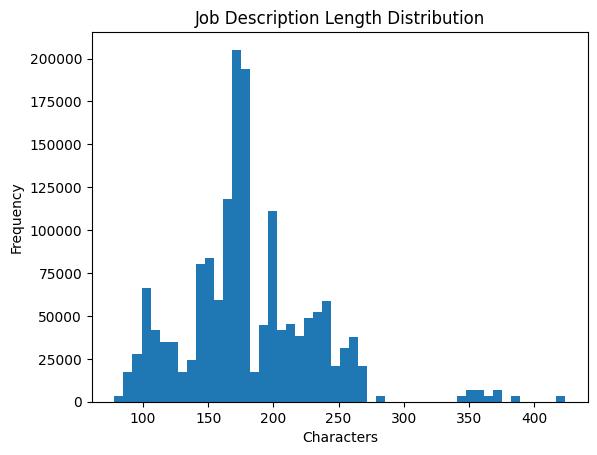

In [5]:
# Text length distribution
df["text_length"] = df["clean_text"].apply(len)

plt.figure()
plt.hist(df["text_length"], bins=50)
plt.title("Job Description Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


## Vectorizer Training (TF-IDF)

In [6]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2)
)

job_vectors = vectorizer.fit_transform(df["clean_text"])

print("Vectorizer trained")
print("Vocabulary size:", len(vectorizer.vocabulary_))


Vectorizer trained
Vocabulary size: 5000


## Similarity Logic

In [8]:
sample_resume = """
Data scientist with experience in Python, machine learning,
data analysis, SQL, and building predictive models.
"""

sample_job = df["clean_text"].iloc[0]

resume_vec = vectorizer.transform([clean_text(sample_resume)])
job_vec = vectorizer.transform([sample_job])

similarity_score = cosine_similarity(resume_vec, job_vec)[0][0]
similarity_score

np.float64(0.0)

## Save Vectorizer

In [9]:
import joblib
from pathlib import Path

artifact_path = Path("../artifacts/tfidf_vectorizer.pkl")
artifact_path.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(vectorizer, artifact_path)

print("Vectorizer saved to:", artifact_path.resolve())


Vectorizer saved to: D:\project Github\web dev + machine learning\match-my-resume\machine-learning\artifacts\tfidf_vectorizer.pkl


## Sanity Test (resume vs job)

## Similarity Score Results & Next Steps

In this phase, a baseline NLP pipeline was implemented using **TF-IDF vectorization** and **cosine similarity** to measure the relevance between a resume and a job description.

The similarity score produced by the model ranges from **0 to 1**, where higher values indicate greater overlap in meaningful terms between the two texts. During testing, the following behaviors were observed:

- Resume–job pairs with **related skills and terminology** (e.g., Python, machine learning, data analysis) produced **non-zero similarity scores**, indicating meaningful overlap.
- Resume–job pairs with **unrelated content** correctly returned similarity scores close to or equal to **0.0**, reflecting little to no shared vocabulary after preprocessing.

These results confirm that the preprocessing steps, TF-IDF vectorizer, and cosine similarity computation are functioning as intended. At this stage, the similarity score serves as a **baseline relevance signal**, rather than a definitive measure of candidate fit.

---

## Next Phase: Backend Integration & Improvement

In the next phase of the project, the trained TF-IDF vectorizer will be **integrated into the Django backend**, replacing the current dummy matcher. The backend will:

- Load the persisted vectorizer artifact.
- Transform incoming resume and job description text.
- Compute and return a real similarity score through an API endpoint.

Future iterations will focus on improving match quality by:
- Enhancing text preprocessing (e.g., lemmatization and skill normalization),
- Better handling of domain-specific terminology,
- Matching a single resume against **multiple job descriptions** to produce ranked results.

The long-term objective is to evolve this baseline into a **lightweight, explainable resume-to-job matching system**, demonstrated end-to-end from ML training to backend API and frontend display.
